<a href="https://colab.research.google.com/github/SheidaTalei/FinalProject/blob/main/SheidaTalei_LSTM_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import regex
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import re
import string

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import MaxPooling1D
from keras.layers import Conv1D


from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.utils import class_weight

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import  auc

In [4]:
#------------------------------------------Empty Rows Removal----------------------------------------------------------------
# This function Will: 1- Remove all empty rows from csv file 2- Save data to the same csv
def removeEmptyRows(fileName):
    df = pd.read_csv(fileName, encoding='utf-8-sig')
    df = df.dropna(subset=['text'], how='all', axis=0) 
    df.to_csv(fileName, header=True, encoding='utf-8-sig',  index=False)
    
    return df

In [5]:
X_and_Y = removeEmptyRows ('/content/drive/MyDrive/Final/Prepared_train_Data_test#1.csv')

Y= X_and_Y.Label
X = X_and_Y.text

In [6]:
X_and_Y_test = removeEmptyRows('/content/drive/MyDrive/Final/Prepared_test_Data_test#1.csv') #Prepared_test_Data_00 
Y_test= X_and_Y_test.Label
X_test = X_and_Y_test.text

In [7]:
#This part helps for handeling imbalanced data
count_0 = 0
count_1 = 0

for i in Y:
    if (i==0):
        count_0 = count_0+1
    else:
        count_1 = count_1 + 1
        

In [8]:
p = count_0 / (count_0 + count_1)

In [9]:
print ("count_0: ",count_0 )
print ("count_1: ",count_1 )

count_0:  2251
count_1:  1735


In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
#converting words to vectors
max_len = 150 #120
tokenizer = Tokenizer(num_words = max_len, lower = True, split = ' ')
tokenizer.fit_on_texts(X )


X = tokenizer.texts_to_sequences(X)

#pad sequence is used to ensure that all sequences in a list have the same length.
X_ready = pad_sequences(sequences = X, maxlen = max_len, padding = 'pre')

In [73]:

def createLstmModel(units = 900, dropout = 0.5  ):
    
    
   #https://www.tensorflow.org/tutorials/text/text_classification_rnn
        
    #Adding Layers
    model = Sequential()
    model.add(Embedding(500 , 128 ))#max_feature = 5000 , embedding_dimention = 128

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))  
   
    # model.add(LSTM(units = units , dropout = 0.2, return_sequences=True ))
    # model.add(Dense(units = units, activation="relu"))
    # model.add(Dropout(rate = dropout))


  
    model.add(LSTM(units = units , dropout = 0.2))
    model.add(Dense(units = units, activation="relu"))
    model.add(Dropout(rate = dropout))

    model.add(Dense(units = 1 ,activation="sigmoid"))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1_m ,tf.keras.metrics.AUC(), 'accuracy'])
    
    # model.fit(X, Y, batch_size = 150, class_weight = {0: 1/66639, 1: 1/(1- (1/66639))})
#     model.summary()
    return model


In [74]:
#source: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=IFPuhwntH8VH
import os
checkpoint_path = "/content/drive/MyDrive/Final/lstm.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [75]:
# print(type(X_ready))

In [76]:
# Fit LSTM model
#source: https://apmonitor.com/do/index.php/Main/LSTMNetwork

# history = model.fit(X_ready, Y , epochs = 2, batch_size = 150, class_weight = {0: 1/66639, 1: 1/(1-66639)})

#400
model = createLstmModel()
history = model.fit(X_ready, 
          Y,  
          epochs=100,
          batch_size = 150,
          callbacks=[cp_callback], class_weight = {0: 1/p, 1: 1/(1-p)} , validation_split = 0.3) 
# plt.figure()
# plt.ylabel('loss'); plt.xlabel('epoch')
# plt.semilogy(history.history['loss'])

Epoch 1/100
19/19 [==============================] - 5s 157ms/step - loss: 1.4453 - f1_m: 0.4410 - auc_8: 0.6028 - accuracy: 0.5558 - val_loss: 0.4008 - val_f1_m: 0.8423 - val_auc_8: 0.9300 - val_accuracy: 0.8478

Epoch 00001: saving model to /content/drive/MyDrive/Final/lstm.ckpt
Epoch 2/100
19/19 [==============================] - 2s 115ms/step - loss: 0.7606 - f1_m: 0.8392 - auc_8: 0.9128 - accuracy: 0.8506 - val_loss: 0.3421 - val_f1_m: 0.8431 - val_auc_8: 0.9351 - val_accuracy: 0.8512

Epoch 00002: saving model to /content/drive/MyDrive/Final/lstm.ckpt
Epoch 3/100
19/19 [==============================] - 2s 116ms/step - loss: 0.6285 - f1_m: 0.8580 - auc_8: 0.9399 - accuracy: 0.8715 - val_loss: 0.3210 - val_f1_m: 0.8533 - val_auc_8: 0.9388 - val_accuracy: 0.8587

Epoch 00003: saving model to /content/drive/MyDrive/Final/lstm.ckpt
Epoch 4/100
19/19 [==============================] - 2s 117ms/step - loss: 0.5824 - f1_m: 0.8710 - auc_8: 0.9448 - accuracy: 0.8818 - val_loss: 0.3173 - v

In [77]:
#source: https://www.tensorflow.org/tutorials/text/text_classification_rnn
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 51.940672389417884)

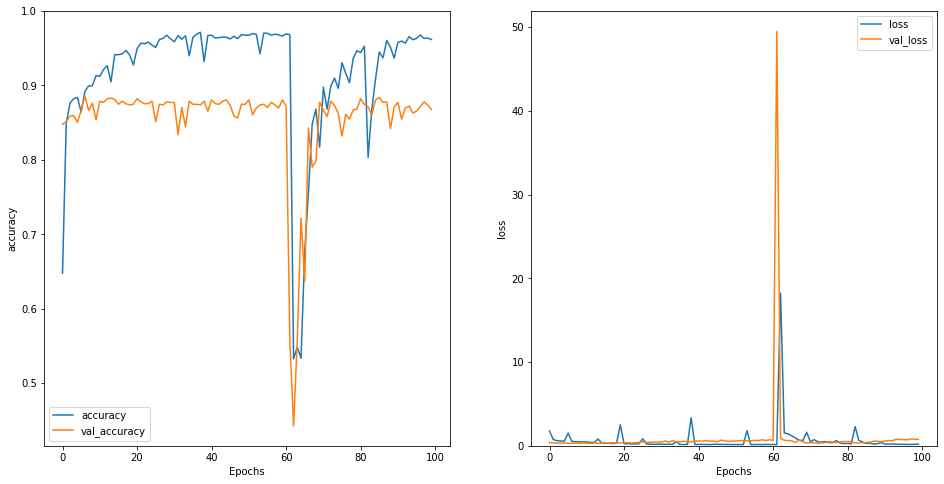

In [78]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [18]:
import os
checkpoint_path = "/content/drive/MyDrive/Final/lstm.ckpt"
model = createLstmModel()
model.load_weights(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
# class_weight = {0: 1/66639, 1: 1/(1- (1/66639))}
# model = KerasClassifier(build_fn=createLstmModel , epochs=1000   )

# # class_weights = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
# # pipeline =  [
# # #         ('tokenizer', Tokenizer(num_words = max_feature, lower = True, split = ' ')),
# # #         ('pad', pad_sequences(sequences = X , maxlen = max_feature, padding = 'pre')),
# #         ('estimator', model)
# #     ]

# parameters = { 'dropout' : [0.5,0.1, 0.01], 'units':[100,  300, 700, 1000] , 'batch_size' :[150]
# #     'tokenizer__num_words': (100, 200, 300),
# #     'pad__maxlen':( 200, 300, 400),
    
#     # 'estimator__dropout': (0.5,0.1, 0.01),
#     # 'estimator__units' :(100,  300, 700, 1000)
   
# }


# #source: https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

# # grid_search_tune = GridSearchCV(Pipeline(pipeline), parameters, cv=20, verbose=1  )

# grid_search_tune = GridSearchCV(model , parameters, cv=20 , verbose=1)

# LSTM = grid_search_tune.fit(X, Y)
#?????????? check batch_size and Class_weight


In [ ]:
# print (grid_search_tune.best_estimator_.steps)

# print ('Best Parameter for LSTM ',grid_search_tune.best_params_)
# print('Best Score for LSTM: ',grid_search_tune.best_score_)

In [68]:

# tokenizer = Tokenizer(num_words = max_len, lower = True, split = ' ')
#converting words to vectors
tokenizer.fit_on_texts(X_test )

X_temp = tokenizer.texts_to_sequences(X_test)

#pad sequence is used to ensure that all sequences in a list have the same length.
X_ready_test = pad_sequences(sequences = X_temp, maxlen = max_len, padding = 'pre')




In [69]:
y_predict =model.predict(X_ready_test)

In [70]:
# print(y_predict)

In [71]:
# print('Accuracy: ' , accuracy_score( Y_test,y_predict))
# #Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
# print('F1-score: ', f1_score(Y_test, y_predict))
# #source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
# print('roc_auc_score: ', roc_auc_score(Y_test, y_predict))

In [79]:
loss, f1_score, auc,accuracy = model.evaluate(X_ready_test, Y_test, verbose=0)
print('Accuracy:  %.3f' , accuracy)

print('F1-score:  %.3f', f1_score)

print('roc_auc_score:  %.3f', auc)


Accuracy:  %.3f 0.6650000214576721
F1-score:  %.3f 0.5891603231430054
roc_auc_score:  %.3f 0.6873294115066528
